In [1]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [2]:
imb = pd.read_csv("../data/imbalance_1h.csv")

In [3]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

imb_2019 = pd.read_csv("../data/imbalance_1h_2019.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)
imb_2020 = pd.read_csv("../data/imbalance_1h_2020.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)

In [4]:
imb_2019.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


In [5]:
imb_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20424 entries, 2019-01-01 00:00:00 to 2021-04-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imbalance_price  20424 non-null  float64
dtypes: float64(1)
memory usage: 319.1 KB


In [6]:
#imb = imb.set_index('datetime')

In [7]:
#imb.drop(['2', 'weekday', 'date'], axis=1, inplace=True)

In [8]:
def train_test_split(df):
    n = int(len(df)*0.7)
    train, test = df.iloc[:n], df.iloc[n:]

    return train,test

In [9]:
train_2019, test_2019 = train_test_split(imb_2019)
train_2020, test_2020 = train_test_split(imb_2020)

In [10]:
print(train_2019.shape, test_2019.shape)
print(train_2020.shape, test_2020.shape)

(14296, 1) (6128, 1)
(8164, 1) (3500, 1)


In [11]:
train_2019.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


<Figure size 1008x1008 with 0 Axes>

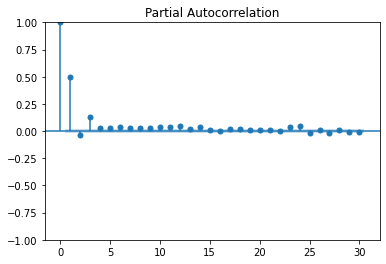

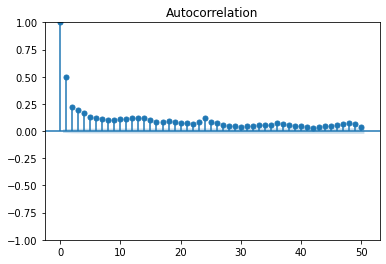

In [12]:
plt.figure(figsize=(14, 14))
pacf = plot_pacf(train_2019, lags=30, alpha=0.05)
acf = plot_acf(train_2019, lags=50, alpha=0.05)

Conclusion : AR (3), MA? (10 or 40)

In [13]:
p_range = range(1,6)
d_range = [1,2]
q_range = [9,10,11,29,30,31]

In [14]:
def best_aic(df, p_range, d_range, q_range):
    aic = []
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                model = ARIMA(df, order=order)
                model_fit = model.fit()
                aic.append([order, model_fit.aic])
                print(order, model_fit.aic)
    return aic

aic_stored = [ (1, 1, 9) 218438.0776477024,
(1, 1, 10) 218438.01246079954,
(1, 1, 11) 218440.0511899708,
(1, 1, 29) 218340.04531203417,
(1, 1, 30) 218338.54849014725,
(1, 1, 31) 218340.52428676168,
(1, 2, 9) 218564.85978435766,
(1, 2, 10) 218549.11981467105,
(1, 2, 11) 218444.7523995524,
(1, 2, 29) 218378.39439223066,
(1, 2, 30) 218372.16868848068,
(1, 2, 31) 218375.07940818206,
(2, 1, 9) 218441.75412751187,
(2, 1, 10) 218432.7815369026,
(2, 1, 11) 218442.93800884116,
(2, 1, 29) 218345.72706959496,
(2, 1, 30) 218338.1428312349,
(2, 1, 31) 218337.6654606091,
(2, 2, 9) 218559.46220384608,
(2, 2, 10) 218544.80879750013,
(2, 2, 11) 218535.00113799973,
(2, 2, 29) 218387.8264022952
(3, 1, 31) 218347.48071973433,]

### Best ARIMA model so far
aic = best_aic(train_2019, [2], [1], [31])

In [15]:
test_2019.iloc[1]

imbalance_price   -49.943
Name: 2020-08-18 17:00:00, dtype: float64

In [16]:
model_best = ARIMA(train_2019, order=(2,1,31))
model_best_fit = model_best.fit()
forecast_1h = model_best_fit.forecast(steps=1)
forecast_1h

2020-08-18 16:00:00    193.573248
Freq: H, dtype: float64

In [17]:
model_best_fit.aic

212790.79073691095

In [18]:
test_2020.iloc[1]

imbalance_price   -268.4625
Name: 2020-12-06 05:00:00, dtype: float64

In [ ]:
model_best20 = ARIMA(train_2020, order=(2,1,31))
model_best_fit20 = model_best20.fit()
forecast_1h_20 = model_best_fit20.forecast(steps=1)
forecast_1h_20

In [ ]:
model_best_fit20.aic

120686.52230650144

In [ ]:
train_2019.iloc[-25:-1]

,imbalance_price
timestamp,
2020-08-17 15:00:00,766.6790
2020-08-17 16:00:00,331.3475
2020-08-17 17:00:00,369.1855
2020-08-17 18:00:00,-68.6675
2020-08-17 19:00:00,644.5335
2020-08-17 20:00:00,71.0485
2020-08-17 21:00:00,174.4305
2020-08-17 22:00:00,-23.3390
2020-08-17 23:00:00,-273.6065


In [20]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(24):
    model_1h = ARIMA(train_2019.iloc[:-(25-i),:], order=(2,1,7))
    model_1h_fit = model_1h.fit()
    forecast_1h = model_1h_fit.forecast(steps=1)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)

2020-08-17 15:00:00    457.938858
Freq: H, dtype: float64
2020-08-17 16:00:00    373.172628
Freq: H, dtype: float64
2020-08-17 17:00:00    213.025771
Freq: H, dtype: float64
2020-08-17 18:00:00    269.418608
Freq: H, dtype: float64
2020-08-17 19:00:00   -10.759792
Freq: H, dtype: float64
2020-08-17 20:00:00    422.736105
Freq: H, dtype: float64
2020-08-17 21:00:00    7.779984
Freq: H, dtype: float64
2020-08-17 22:00:00    209.202409
Freq: H, dtype: float64
2020-08-17 23:00:00    37.681991
Freq: H, dtype: float64
2020-08-18   -64.514842
Freq: H, dtype: float64
2020-08-18 01:00:00    10.979887
Freq: H, dtype: float64
2020-08-18 02:00:00   -183.726463
Freq: H, dtype: float64
2020-08-18 03:00:00   -12.578646
Freq: H, dtype: float64
2020-08-18 04:00:00    2.944203
Freq: H, dtype: float64
2020-08-18 05:00:00    146.506786
Freq: H, dtype: float64
2020-08-18 06:00:00    126.893466
Freq: H, dtype: float64
2020-08-18 07:00:00    70.467323
Freq: H, dtype: float64
2020-08-18 08:00:00   -232.217052

In [21]:
forecast_1h_df = train_2019.iloc[-25:-1]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

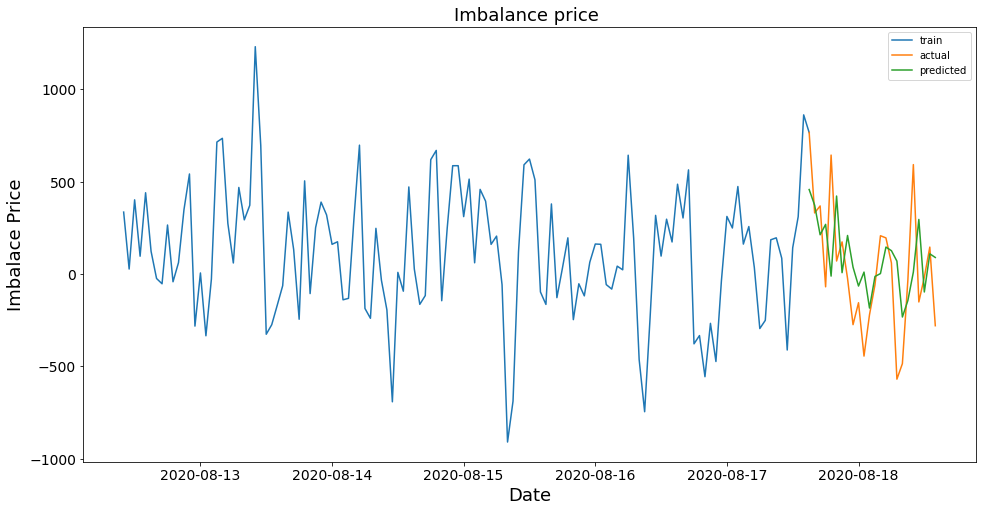

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-24], label='train')
plt.plot(forecast_1h_df['imbalance_price'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.savefig('imb_price_train_test_arima_1h.png')

In [23]:
np.sqrt(mean_squared_error(forecast_1h_df['imbalance_price'].values, forecast_1h_df['predicted'].values))

316.3310634871569

In [ ]:
train_2019.iloc[-150:-25]

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error())

In [28]:
#for i in range(len(test_2019)):
forecasts_6h = []
for i in range(0,24,6):
    model_6h = ARIMA(train_2019.iloc[:-(25-i),:], order=(2,1,7))
    model_6h_fit = model_6h.fit()
    forecast_6h = model_6h_fit.forecast(steps=6)
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-08-17 15:00:00    457.938858
2020-08-17 16:00:00    215.031158
2020-08-17 17:00:00    186.804066
2020-08-17 18:00:00    154.360982
2020-08-17 19:00:00    110.536118
2020-08-17 20:00:00    105.468761
Freq: H, Name: predicted_mean, dtype: float64
2020-08-17 21:00:00      7.779984
2020-08-17 22:00:00    125.419474
2020-08-17 23:00:00    131.720098
2020-08-18 00:00:00    108.379550
2020-08-18 01:00:00    120.265317
2020-08-18 02:00:00    121.496040
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 03:00:00   -12.578646
2020-08-18 04:00:00    26.210504
2020-08-18 05:00:00    48.630590
2020-08-18 06:00:00    75.986324
2020-08-18 07:00:00    80.562780
2020-08-18 08:00:00    82.297769
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 09:00:00   -142.857622
2020-08-18 10:00:00    -43.296123
2020-08-18 11:00:00    -17.782585
2020-08-18 12:00:00     24.525237
2020-08-18 13:00:00     46.281686
2020-08-18 14:00:00     49.894842
Freq: H, Name: predicted_mean, dtype: float64


In [29]:
forecasts_6h = np.array(forecasts_6h).reshape(24,1)

In [30]:
forecast_6h_df = train_2019.iloc[-25:-1]
forecast_6h_df['predicted'] = np.array(forecasts_6h)

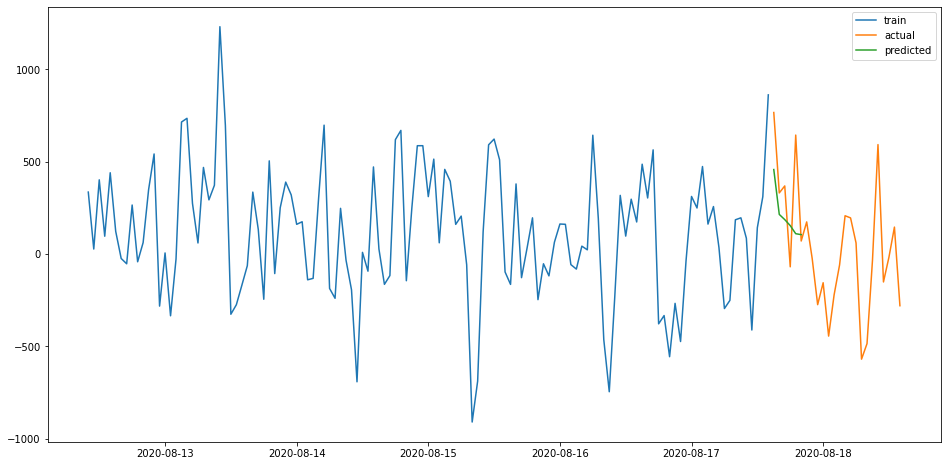

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[:6], label='predicted')
plt.legend()

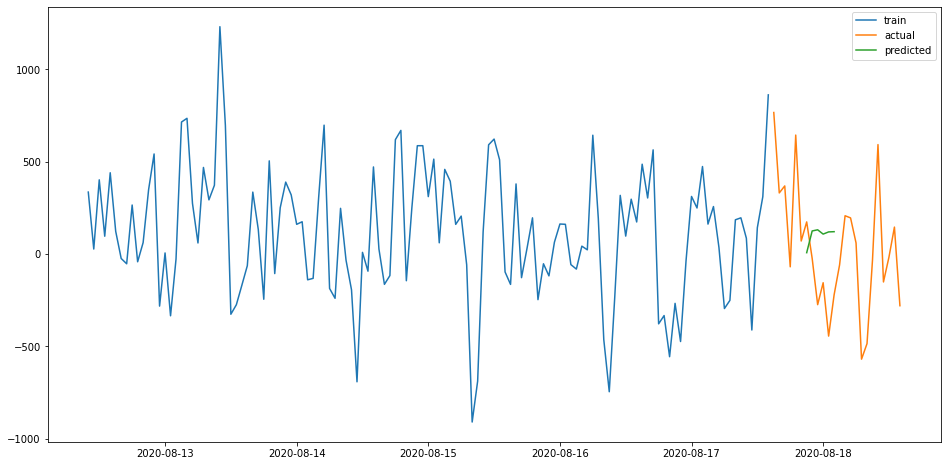

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[6:12], label='predicted')
plt.legend()

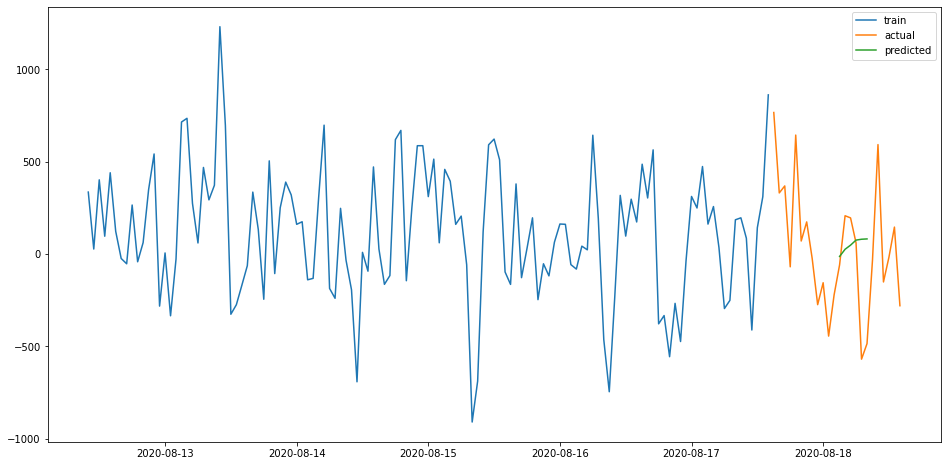

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[12:18], label='predicted')
plt.legend()

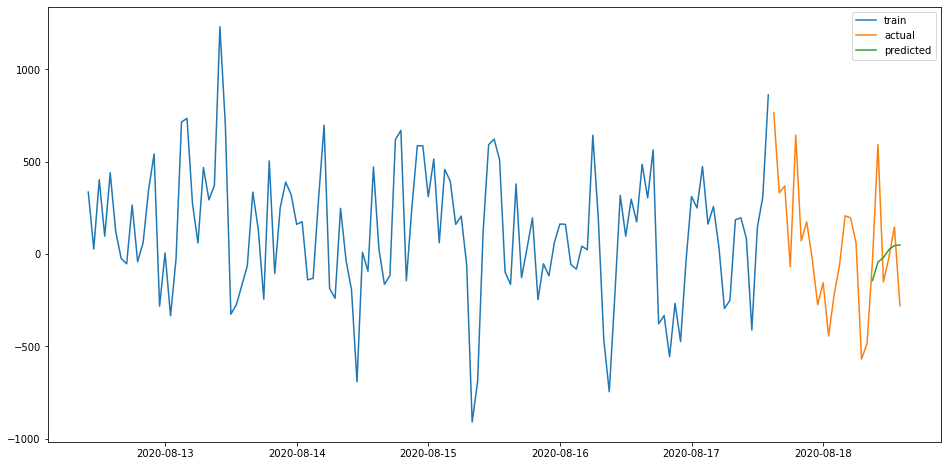

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[18:], label='predicted')
plt.legend()

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()

In [ ]:
plt.figure(figsize=(14,6))
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals, label='residuals')
#plt.plot(train_2019, label= 'original', alpha=0.5)
plt.legend()